In [2]:
# combine variables in EDF to get full variability of QoI

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from adj_utils import load_output,get_grid
import sys
sys.path.append('/glade/u/home/noahrose/ECCOv4-py')
import ecco_v4_py as ecco
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import Normalize
from cmocean import cm

In [3]:
#varnames = ['qnet','tauu','tauv']
varnames = ['tauu','tauv']
ecco_varnames=['oceTAUE','oceTAUN']
#ecco_varnames = ['oceQnet','oceTAUE','oceTAUN']

In [4]:
## first try just with full basin

depth = 700
suffix = '_v2'

adj_full = load_output(f'/glade/work/noahrose/emu_so_hc/emu_adj_301_312_3_SO_T{depth}_full_mask{suffix}.bin_1/')
adj_atl = load_output(f'/glade/work/noahrose/emu_so_hc/emu_adj_301_312_3_SO_T{depth}_Atl_mask{suffix}.bin_1/')
adj_pac = load_output(f'/glade/work/noahrose/emu_so_hc/emu_adj_301_312_3_SO_T{depth}_Pac_mask{suffix}.bin_1/')
adj_ind = load_output(f'/glade/work/noahrose/emu_so_hc/emu_adj_301_312_3_SO_T{depth}_Ind_mask{suffix}.bin_1/')

ratio_ind_atl = 140./(140.+80.)

adj_ds = adj_full#adj_pac - (adj_ind * ratio_ind_atl + adj_atl * (1 - ratio_ind_atl))

llc_compact_to_faces: dims, llc  (1358, 1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (1358, 13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
llc_compact_to_faces: dims, llc  (1358, 1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (1358, 13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
llc_compact_to_faces: dims, llc  (1358, 1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (1358, 13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
llc_compact_to_faces: dims, llc  (1358, 1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (1358, 13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
llc_compact_to_faces: dims, llc  (1358, 1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (1358, 13, 90, 90)
llc_faces_to_tiles: data_ti

In [5]:
adj_arr = [adj_ds[v] for v in varnames]

nl,ny,nx = adj_arr[0].shape
adj_arr = [a.to_numpy().reshape(nl,nx*ny) for a in adj_arr]

In [6]:
adj_arr_norm = adj_arr#[(a - np.mean(a))/np.std(a) for a in adj_arr]

In [7]:
adj_arr_norm = np.hstack(adj_arr_norm)

In [8]:
ecco_arr = [xr.open_mfdataset(f'/glade/work/noahrose/ECCOV4r4/nctiles_monthly/{ecco_varname}/*/*.nc')[ecco_varname]
            for ecco_varname in ecco_varnames]

In [9]:
ecco_arr_anom = [da.groupby('time.month') - da.groupby('time.month').mean('time') for da in ecco_arr]

In [10]:
grid = get_grid()

In [11]:
new_grid_delta_lat = 1
new_grid_delta_lon = 1

new_grid_min_lat = -90
new_grid_max_lat = 90

new_grid_min_lon = -180
new_grid_max_lon = 180

ecco_arr_rg = []
for i in range(len(varnames)):

    lons, lats,\
    new_grid_lon_edges, new_grid_lat_edges,\
        ecco_rg =\
                ecco.resample_to_latlon(grid.XC, \
                                        grid.YC, \
                                        ecco_arr_anom[i],\
                                        new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,\
                                        new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,\
                                        fill_value = np.nan, \
                                        mapping_method = 'nearest_neighbor',
                                        radius_of_influence = 120000);
    ecco_arr_rg.append(ecco_rg)

In [12]:
ecco_arr_rg = [np.where((lats <= 90),a,0) for a in ecco_arr_rg]


In [13]:
ecco_arr_norm = ecco_arr_rg#[(a - np.mean(a))/np.std(a) for a in ecco_arr_rg]

In [14]:
nt,_,_ = ecco_arr_norm[0].shape
ecco_arr_norm = [a.reshape(nt,nx*ny) for a in ecco_arr_norm]
ecco_arr_norm = np.hstack(ecco_arr_norm)

In [15]:
np.nanmax(adj_arr_norm[0][100])

np.float32(-0.0)

In [16]:
cov = ecco_arr_norm.dot(adj_arr_norm.T)

In [17]:
U,S,V = np.linalg.svd(cov,full_matrices=False)

In [18]:
EDFs = ecco_arr_norm.T.dot(U)

In [19]:
EDF_arr = np.vsplit(EDFs,len(varnames))
#EDF_arr = [a.T for a in EDF_arr]

In [58]:
def plot_pattern(arr,num_patterns,text='',figsize=(8,12),var='qnet',suptitle=None,cbarlabel=None):
    fig,axs = plt.subplots(1,num_patterns,figsize=figsize,subplot_kw={'projection':ccrs.Orthographic(0,-90)},
                          layout='compressed')
    if (var == 'qnet'):
        hr = np.nanmax(abs(arr))
        for i,ax in enumerate(axs):
            im = ax.pcolormesh(lons,lats,arr[:,i].reshape(ny,nx),cmap="RdBu_r",
                               norm=colors.CenteredNorm(halfrange=hr),transform=ccrs.PlateCarree())
            ax.add_feature(cfeature.LAND,facecolor='gray',zorder=100)
            ax.set_title(f'{text} {i+1}')
        fig.colorbar(im, ax=axs.ravel().tolist(),label=cbarlabel)
    elif ((var == 'tau')):

        for i,ax in enumerate(axs):
            widthfactor=1
            
            uvals = (arr[0][:,i]).reshape(ny,nx)
            vvals = (arr[1][:,i]).reshape(ny,nx)
            MAG=np.sqrt(uvals**2+ vvals**2)
            norm = Normalize(vmin=np.min(MAG),vmax=np.max(MAG))
            
            
            
            
            im = ax.streamplot(lons,lats,u=uvals,
                       v=vvals,
                           transform=ccrs.PlateCarree(),
                          linewidth=(widthfactor*MAG/np.max(MAG)),
                           density = 1.2,
                           broken_streamlines=False,
                          color = MAG,
                          cmap = cm.amp,
                           maxlength=0.5,
                          arrowstyle='fancy')
            
            ax.add_feature(cfeature.LAND,facecolor='gray',zorder=100)
            ax.set_title(f'{text} {i+1}')
        fig.colorbar(im.lines, ax=axs.ravel().tolist(),label=cbarlabel)
    if (suptitle != None):
        plt.suptitle(suptitle,y=0.65)


In [21]:
#plot_pattern(EDF_arr[0].T,3,text='EDF',var='qnet')

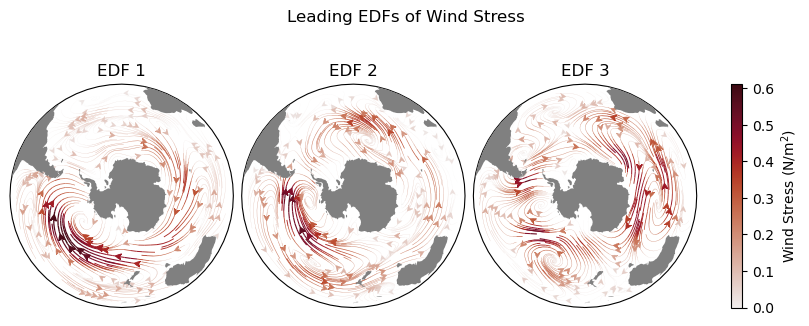

In [22]:
plot_pattern([EDF_arr[0],EDF_arr[1]],3,text='EDF',var='tau',
             suptitle ='Leading EDFs of Wind Stress',
            cbarlabel=r'Wind Stress (N/m${^2}$)')

0.94725114


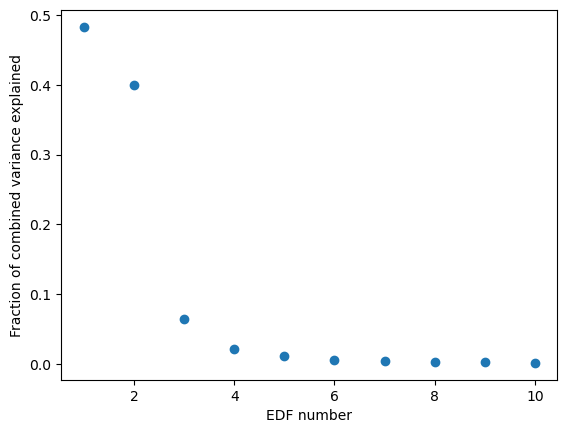

In [23]:
plt.plot(range(1,11),((S**2)/((S**2).sum()))[:10],'o')
plt.ylabel('Fraction of combined variance explained')
plt.xlabel('EDF number')
print((((S**2)/((S**2).sum()))[:3]).sum())

[[1.         0.11409548]
 [0.11409548 1.        ]]


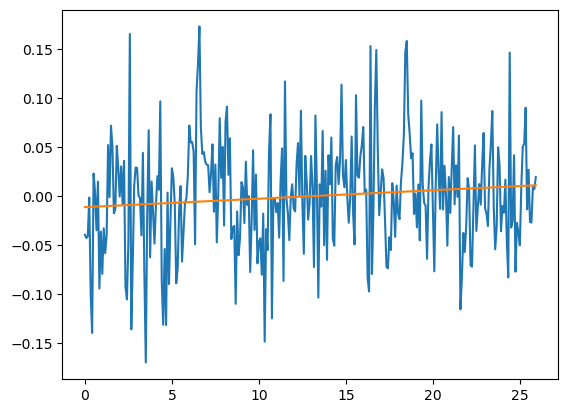

In [24]:
t = np.arange(312)/12

plt.plot(t,U[:,0])

b,a = np.polyfit(t,U[:,0],1)

plt.plot(t,b*t+a)
print(np.corrcoef(t,U[:,0]))

In [25]:
U_a,S_a,_ = np.linalg.svd(adj_arr_norm,full_matrices=False)
SOs = adj_arr_norm.T.dot(U_a)
SOs = np.vsplit(SOs,len(varnames))

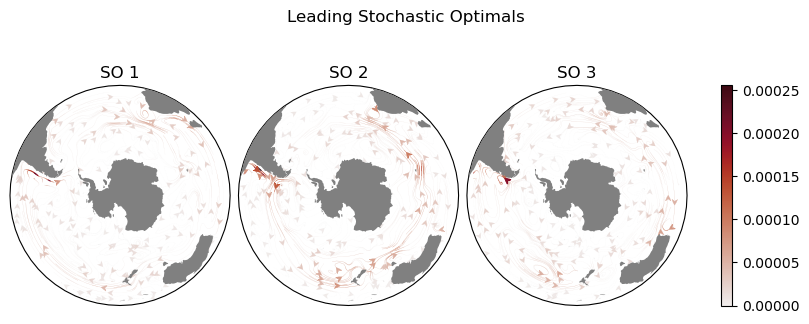

In [59]:
plot_pattern([SOs[0],SOs[1]],3,text='SO',var='tau',suptitle = 'Leading Stochastic Optimals')

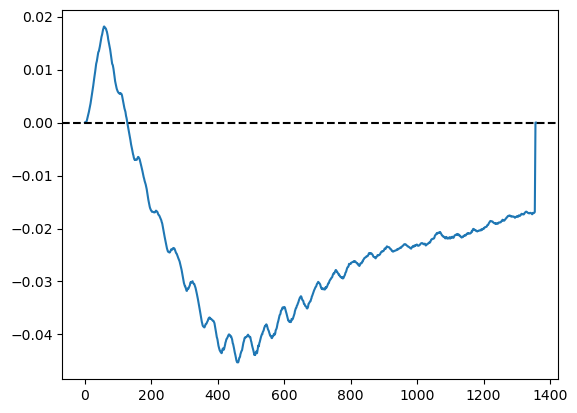

In [67]:
plt.plot(U_a[::-1,0])
plt.axhline(0,ls='--',c='k')

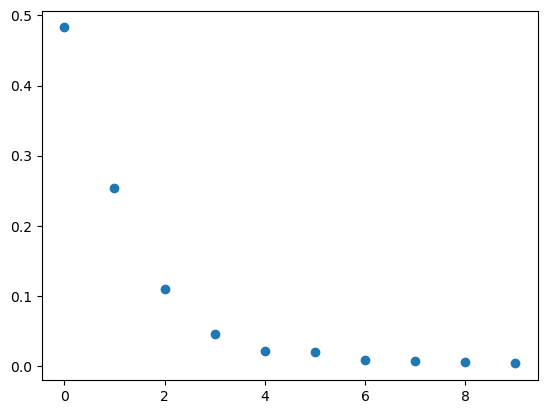

In [27]:
plt.plot((S_a**2/((S_a**2).sum()))[:10],'o')

In [28]:
U_f,S_f,_ = np.linalg.svd(ecco_arr_norm,full_matrices=False)
EOFs = ecco_arr_norm.T.dot(U_f)
EOFs = np.vsplit(EOFs,len(varnames))

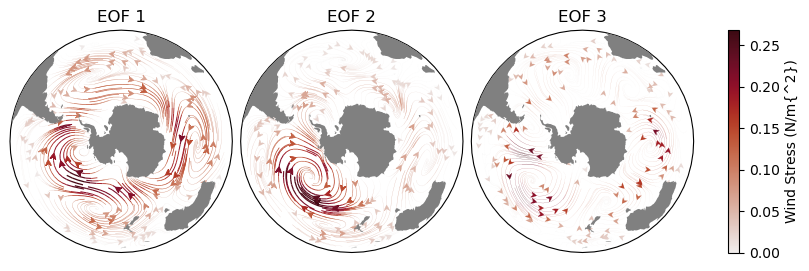

In [29]:
plot_pattern([EOFs[0],EOFs[1]],3,text='EOF',var='tau',
            cbarlabel=r'Wind Stress (N/m{^2})')

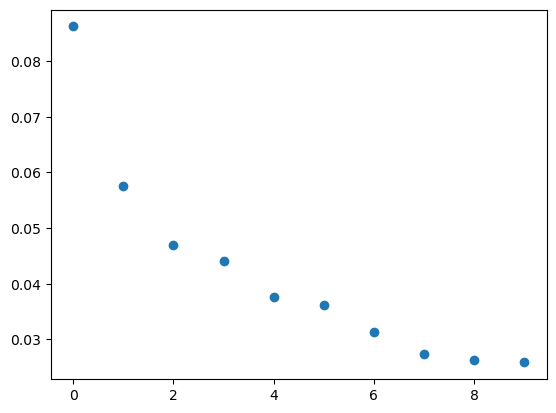

In [30]:
plt.plot((S_f**2/((S_f**2).sum()))[:10],'o')